<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

# Table of Contents:
- [Import Libraries](#Import-Libraries)
- [Functions](#Functions)
- [Import Data](#Import-Data)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

# Import Libraries

In [1]:
# Basics
import numpy as np
import pandas as pd
import time

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats

%matplotlib inline
plt.style.use('ggplot')

# Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Optimizing hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Modeling and model evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score

# Modeling - KNeigbors Classifier
from sklearn.neighbors import KNeighborsClassifier

# Modelling - Logistic Regression
from sklearn.linear_model import LogisticRegression

# Modelling - Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


---

# Functions

In [2]:
# Function to calculate and display classification metrics
def class_metrics(model, X, y):
    # Generate predictions
    y_pred = model.best_estimator_.predict(X)
    y_pred_prob = model.best_estimator_.predict_proba(X_test)[:,1]
    # confusion matrix and unravel
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Accuracy
    accuracy = round((tp+tn)/len(y), 2)
    print(f'Accuracy: {accuracy}')
    # Sensitivity
    sensitivity = round(tp/(tp+fn), 2)
    print(f'Sensitivity: {sensitivity}')
    # Specificity
    specificity = round(tn/(tn+fp), 2)
    print(f'Specificity: {specificity}')
    # Precision
    precision = round(tp/(tp+fp), 2)
    print(f'Precision: {precision}')
    # F1-Score
    f1score = round(f1_score(y, y_pred, average='binary'), 2)
    print(f'F1: {f1score}')
    # AUC Score
    auc = round(roc_auc_score(y, y_pred_prob), 2)
    print(f'AUC: {auc}')
    
    # Return y_pred, y_pred_prob, and auc score for plotting roc curve and other variables for usage later
    return y_pred, y_pred_prob, accuracy, sensitivity, specificity, precision, f1score, auc


In [3]:
def confusion_matrix_plot(y_test, y_pred, title):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    hm = sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = 'Blues')
    hm.set_title(title)

In [4]:
# Plot ROC curve
def plot_roc_auc(y_pred_prob, auc, model_title, tranformation_title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--', label = 'baseline')
    plt.plot(fpr, tpr, label = f'AUC = {auc}', color = 'teal')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_title}, {tranformation_title} (ROC Curve)')
    plt.legend()
    plt.show()

In [5]:
# Display all observations that have been classified wrongly
def display_misclassification(y_pred):
    pd.options.display.max_colwidth = 120
    pd.options.display.max_rows = 150
    combined = list(zip(X_test, y_test, y_pred))
    misclassification = pd.DataFrame(columns = ["text", "actual", "predicted"]) 
    for text, actual, prediction in combined:
        if actual != prediction:
            row = pd.DataFrame({'text':[text], 'actual':[actual], 'predicted':[prediction]})
            misclassification = misclassification.append(row, ignore_index = True)
            
    for i in ['actual', 'predicted']:
        misclassification[i] = misclassification[i].map({0: 'surfing', 1: 'scubadiving'})
        
    return misclassification


---

# Import Data

In [6]:
# Import cleaned subreddits
df = pd.read_csv("../data/subreddits_cleaned.csv")

In [7]:
df.head()

,Unnamed: 0,diving,text
0,0,1,go tomorrow open water cert doc told swimmer e...
1,1,1,swimmer ear
2,2,1,big hungry fish
3,3,1,dusk blue heron bridge rivera beach fl usa x20...
4,4,1,mark v inspire helmet lamp decoration building


In [8]:
# drop 'Unnamed: 0' column
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
df.isna().sum()

diving     0
text      25
dtype: int64

In [10]:
df[df['text'].isna()]

,diving,text
35,1,NaN
41,1,NaN
91,1,NaN
101,1,NaN
177,1,NaN
253,1,NaN
590,1,NaN
677,1,NaN
706,1,NaN
708,1,NaN


In [11]:
df = df.dropna().reset_index(drop = True)

In [12]:
df[df['text'].isna()]

,diving,text


In [13]:
df.isna().sum()

diving    0
text      0
dtype: int64

---

# Modeling
To find out which is the best machine learning model for our classification problem, we will be building 8 different types of models for comparison purposes. These models will be built upon 4 different types of supervised machine learning classification algorithms, including Logistic Regression, Random Forest Classifier, KNeignbors Classifier and Naives Bayes, and 2 different word vectorizers, CountVectorizer and Tfidf Vectorizer. 

Hyperparameter tuning using GridSearchCV will be done to determine the optimal hyperparameters, in order to extract the maximum performance out of each machine learning model.



## Machine Learning Algorithms Used:
### Logistic Regression
Logistic regression is a calculation used to predict a binary outcome: either something happens, or does not. This can be exhibited as Yes/No, Pass/Fail, Alive/Dead, and in the case of this project, whether the a subreddit text belongs to scubadiving or not. Independent variables are analyzed to determine the binary outcome with the results falling into one of two categories. The independent variables can be categorical or numeric, whereas the dependent/target variable is always categorical.

### Random Forest Classifier
Random forest Classifier is a classification Algorithm Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. The key principle underlying the random forest approach comprises the construction of many “simple” decision trees in the training stage and the majority vote (mode) across them in the classification stage. Among other benefits, this voting strategy has the effect of correcting for the undesirable property of decision trees to overfit training data

### KNeighbors Classifier
K-nearest neighbors (k-NN) is a pattern recognition algorithm that uses training datasets to find the k closest relatives in future examples. When k-NN is used in classification, you calculate to place data within the category of its nearest neighbor. If k = 1, then it would be placed in the class nearest 1. K is classified by a plurality poll of its neighbors. [(source)](https://monkeylearn.com/blog/classification-algorithms/)

## Vectorizers Used:
### Count Vectorizer
Count vectorizer is a basic vectorizer which takes each word token from the dataset and turns it into a feature. As a whole it converts a collection of text documents to a sparse matrix of token counts.

### Tfidf Vectorizer
TF-IDF (term frequency–inverse document frequency) vectorizes words by taking into account the frequency of a word in a given text and the frequency between text. The importance increases proportionally to the number of times a word appears in the text but is offset by the frequency of the word in the corpus. If a word is common in most text, the word is suppressed and rare words are given more influence showing they are highly specific for a particular document.

## Train Test Split

In [14]:
X = df['text']
y = df['diving']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

---

## Baseline Model
### Zero Rate Classifier
For a two outcome model, it will be right more often than not by just going with the odds. Selecting the majority group (ZeroR classifier) is insightful as a baseline. In this case, we have a balanced classification problem, hence we will just use 0.50 as the baseline accuracy score.

In [15]:
df["diving"].value_counts(normalize = True)

0    0.501545
1    0.498455
Name: diving, dtype: float64

---

## Logistic Regression - CountVectorizer
### Model with best scores after hypertuning:

In [16]:
# Set up pipeline
lr_cvec_pipe = Pipeline([('cvec', CountVectorizer()), 
                         ('lr', LogisticRegression(random_state = 42))])

# Hyperparameters tuning
lr_cvec_params = {'cvec__ngram_range' : [(1, 1), (1, 2)],
                  'cvec__max_features' : [6500, 6700, 6900],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'lr__C': np.linspace(0.3, 1, 10),
                  'lr__solver':['liblinear'],
                  'lr__penalty' : ['l1', 'l2']}

# GridSearchCV
lr_cvec_gs = GridSearchCV(lr_cvec_pipe, 
                          param_grid = lr_cvec_params, 
                          cv = 5,
                          verbose = 1,
                          n_jobs = -1) 

start_time = time.time()

# Fit model
lr_cvec_gs.fit(X_train, y_train)

# Show metrics and best parameters
print(lr_cvec_gs.best_params_)
lc_y_pred, lc_y_pred_prob, lc_accuracy, lc_sensitivity, lc_specificity, lc_precision, lc_f1score, lc_auc = class_metrics(
    lr_cvec_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'cvec__max_features': 6700, 'cvec__ngram_range': (1, 1), 'lr__C': 0.45555555555555555, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Accuracy: 0.85
Sensitivity: 0.81
Specificity: 0.89
Precision: 0.88
F1: 0.84
AUC: 0.93
Elapsed time: 10.24 seconds


#### Hyperparameters Setting Example 1:

lr_cvec_params = {'cvec__ngram_range' : [(1, 1), (1, 2)],
                  'cvec__max_features' : [5500, 6000, 6500, 7000],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'lr__C': np.linspace(0.7, 2, 10),
                  'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'lr__penalty' : ['l1', 'l2', 'elasticnet', None]}

                  
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits

{'cvec__max_features': 7000, 'cvec__ngram_range': (1, 2), 'lr__C': 0.8444444444444444, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

Accuracy: 0.85
Sensitivity: 0.82
Specificity: 0.89
Precision: 0.88
F1: 0.85
AUC: 0.93

Elapsed time: 234.71 seconds

#### Note:
'cvec__max_df' : [.9, .95]' and 'cvec__min_df' : [0.5, 1]' were removed from the params as they did not make a difference to the score metrics.

### Confusion Matrix

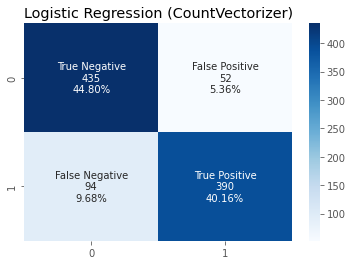

In [17]:
confusion_matrix_plot(y_test, lc_y_pred, 'Logistic Regression (CountVectorizer)')

### ROC Curve and AUC

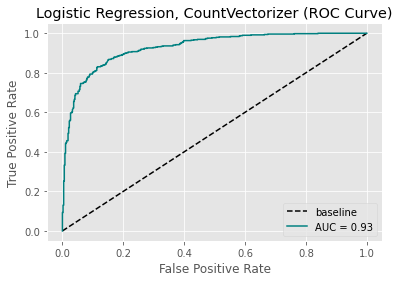

In [18]:
plot_roc_auc(lc_y_pred_prob, lc_auc, 'Logistic Regression', 'CountVectorizer')

With a AUC score of 0.93, this model is quite a good model as it has a decently strong ability to measure separability between the the two subreddit categories.

### Misclassified Observations

In [19]:
display_misclassification(lc_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,maybe research implication well,scubadiving,surfing
2,joe rogan experience 1749 shane dorian,surfing,scubadiving
3,place north shore hi everyone new hop see knew good place north shore massachusetts place gloucester rockport area t...,scubadiving,surfing
4,silent bubble watch computer right know danger silent bubble safe stay healthy avoid dc scubadiving,scubadiving,surfing
5,albino cowry small large,scubadiving,surfing
6,mentawaii island 2019 5 u perfect poo stance love go back someday,surfing,scubadiving
7,hand point unadorned left ring finger pause moment think problem,scubadiving,surfing
8,pretty fishies short compilation,scubadiving,surfing
9,shark kill dolphin brings shore,surfing,scubadiving


### Word Coefficients

##### Words with Positive Coefficients

In [20]:
coef_names = lr_cvec_gs.best_estimator_.named_steps.cvec.get_feature_names()
coef_vals = np.exp(lr_cvec_gs.best_estimator_.named_steps['lr'].coef_[0])

coef_df = pd.DataFrame ({
    'word' : coef_names,
    'coef' : coef_vals}).set_index('word')

coef_df.reindex(coef_df['coef'].sort_values(ascending=False).index)[:20]

,coef
word,
underwater,9.126561
bali,6.073792
sea,4.404043
certify,4.274190
gear,3.921422
octopus,3.776680
reef,3.549618
wreck,3.262400
open,3.222710


##### Words with Negative Coefficients

In [21]:
coef_df.reindex(coef_df['coef'].sort_values(ascending=True).index)[:20]

,coef
word,
repair,0.309860
kook,0.317952
paddle,0.320519
winter,0.340725
shape,0.362258
session,0.369450
ride,0.370921
yesterday,0.379316
custom,0.387861


---

# Logistic Regression - TfidfVectorizer 

In [22]:
# Set up pipleline
lr_tfidf_pipe = Pipeline([('tfidf',TfidfVectorizer()),
                          ('lr',LogisticRegression(random_state= 42))])

# Pipe parameters
lr_tfidf_params = {'tfidf__max_features': [6500, 6800, 7000],
                   'tfidf__ngram_range': [(1,1), (1,2)],
                   'lr__penalty': ['l1', 'l2'],
                   'lr__solver':['liblinear'], 
                   'lr__C': np.linspace(1, 4, 20)}

start_time = time.time()

# tfidf grid search
# Instantiate GridSearchCV.
lr_tfidf_gs = GridSearchCV(lr_tfidf_pipe, 
                           lr_tfidf_params, 
                           cv = 5,
                           verbose = 1,
                           n_jobs = 7) 

# Fit grid search
lr_tfidf_gs.fit(X_train, y_train)

# Show best params, metrics and unpack function return values into variables
print(lr_tfidf_gs.best_params_)
lt_y_pred, lt_y_pred_prob, lt_accuracy, lt_sensitivity, lt_specificity, lt_precision, lt_f1score, lt_auc = class_metrics(
    lr_tfidf_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'lr__C': 1.9473684210526314, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_features': 6800, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.87
Sensitivity: 0.83
Specificity: 0.9
Precision: 0.9
F1: 0.86
AUC: 0.94
Elapsed time: 29.38 seconds


#### Hyperparameters setting example 1:
lr_tfidf_params = {'tfidf__max_features': [7100, 7200, 7300],
                   'tfidf__ngram_range': [(1,1), (1,2)],
                   'lr__penalty': ['l1', 'l2'],
                   'lr__solver':['liblinear'], 
                   'lr__C': np.linspace(4, 7, 20)}
                   
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

{'lr__C': 4.0, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_features': 7100, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.87
Sensitivity: 0.83
Specificity: 0.9
Precision: 0.89
F1: 0.86
AUC: 0.94

Elapsed time: 58.96 seconds
   

#### Hyperparameters setting example 2:
lr_tfidf_params = {'tfidf__max_features': [5000, 5500, 6000],
                   'tfidf__ngram_range': [(1,1), (1,2)],
                   'lr__penalty': ['l1', 'l2'],
                   'lr__C': np.linspace(0.01, 1.5, 20)}
                   
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

{'lr__C': 1.0, 'lr__penalty': 'l2', 'tfidf__max_features': 5500, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.87
Sensitivity: 0.84
Specificity: 0.91
Precision: 0.9
F1: 0.87
AUC: 0.94

Elapsed time: 42.75 seconds


#### Note:
From the above example, it can be seen that adding 'tfidf__max_df' : [0.1, 0.4, 0.7]' and 'tfidf__min_df' : [0.7, 1, 1.2]' to the parameters did not help to improve the model, hence it was removed so that the model can run more efficiently.



### Confusion Matrix

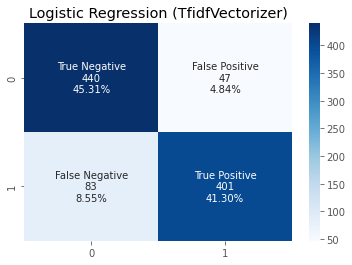

In [23]:
confusion_matrix_plot(y_test, lt_y_pred, 'Logistic Regression (TfidfVectorizer)')

### ROC Curve and AUC

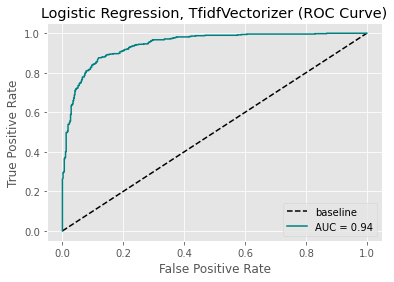

In [24]:
plot_roc_auc(lt_y_pred_prob, lt_auc, 'Logistic Regression', 'TfidfVectorizer')

With a AUC score of 0.94, this model has a better AUC score that the Logistic Regression Model and Count Vectorizer, which means that this is a good model with good measure of separability between the two subreddit categories.

### Misclassified Observations

In [25]:
display_misclassification(lt_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,maybe research implication well,scubadiving,surfing
2,joe rogan experience 1749 shane dorian,surfing,scubadiving
3,place north shore hi everyone new hop see knew good place north shore massachusetts place gloucester rockport area t...,scubadiving,surfing
4,also hate fish bite,scubadiving,surfing
5,albino cowry small large,scubadiving,surfing
6,mentawaii island 2019 5 u perfect poo stance love go back someday,surfing,scubadiving
7,hand point unadorned left ring finger pause moment think problem,scubadiving,surfing
8,pretty fishies short compilation,scubadiving,surfing
9,shark kill dolphin brings shore,surfing,scubadiving


In [26]:
coef_names = lr_tfidf_gs.best_estimator_.named_steps['tfidf'].get_feature_names()
coef_vals = lr_tfidf_gs.best_estimator_.named_steps['lr'].coef_[0]

coef_df = pd.DataFrame ({
    'word' : coef_names,
    'coef' : coef_vals}).set_index('word')

coef_df.reindex(coef_df['coef'].sort_values(ascending=False).index)[:20]

,coef
word,
underwater,5.389985
bali,3.697885
certify,3.484016
sea,3.435655
gear,3.107958
open,2.912474
reef,2.888953
padi,2.836446
computer,2.748913


In [27]:
coef_df.reindex(coef_df['coef'].sort_values(ascending = True).index)[:20]

,coef
word,
kook,-2.794064
paddle,-2.710103
repair,-2.705063
winter,-2.442005
shape,-2.432595
break,-2.298682
ride,-2.242291
session,-2.237703
swell,-2.146998


---

# Random Forest - CountVectorization

In [28]:
# Set up pipeline
rf_cvec_pipe = Pipeline([('cvec', CountVectorizer()), 
                         ('rf', RandomForestClassifier(random_state = 42))])

# Hyperparameters tuning
rf_cvec_params = {'cvec__max_features': [6000, 6500, 7000],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'rf__n_estimators' : [1100, 1200, 1300],
                  'rf__max_depth': [2, 3, 4]}

# GridSearchCV
rf_cvec_gs = GridSearchCV(rf_cvec_pipe, 
                          param_grid = rf_cvec_params, 
                          cv = 5,
                          verbose = 1,
                          n_jobs = -1) 

start_time = time.time()

# Fit model
rf_cvec_gs.fit(X_train, y_train)

# Show best params, metrics and unpack values into variables
print(rf_cvec_gs.best_params_)
rc_y_pred, rc_y_pred_prob, rc_accuracy, rc_sensitivity, rc_specificity, rc_precision, rc_f1score, rc_auc = class_metrics(
    rf_cvec_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'cvec__max_features': 6500, 'cvec__ngram_range': (1, 2), 'rf__max_depth': 3, 'rf__n_estimators': 1200}
Accuracy: 0.8
Sensitivity: 0.83
Specificity: 0.78
Precision: 0.79
F1: 0.81
AUC: 0.89
Elapsed time: 46.44 seconds


#### Hyperparameters setting 1:
rf_cvec_params = {'cvec__max_features': [5500, 6000, 6500],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'rf__n_estimators' : [1000, 1100, 1200],
                  'rf__max_depth': [4, 5, 6]}
                  
Fitting 5 folds for each of 54 candidates, totalling 270 fits

{'cvec__max_features': 6500, 'cvec__ngram_range': (1, 2), 'rf__max_depth': 4, 'rf__n_estimators': 1000}

Accuracy: 0.8
Sensitivity: 0.85
Specificity: 0.73
Precision: 0.76
F1: 0.8
AUC: 0.89

Elapsed time: 158.37 seconds

### Confusion Matrix

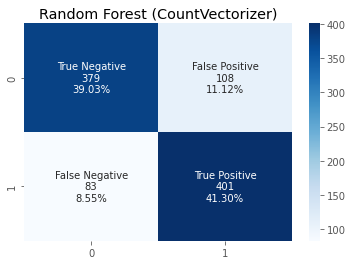

In [29]:
confusion_matrix_plot(y_test, rc_y_pred, 'Random Forest (CountVectorizer)')

### ROC Curve and AUC

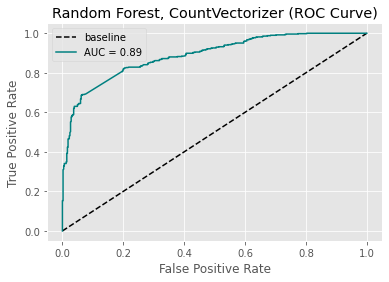

In [30]:
plot_roc_auc(rc_y_pred_prob, rc_auc, 'Random Forest', 'CountVectorizer')

### Misclassified Observations

In [31]:
display_misclassification(rc_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,maybe research implication well,scubadiving,surfing
2,joe rogan experience 1749 shane dorian,surfing,scubadiving
3,place north shore hi everyone new hop see knew good place north shore massachusetts place gloucester rockport area t...,scubadiving,surfing
4,tray gopro 4 know good tray room 2 mountable light buy sweden,scubadiving,surfing
...,...,...,...
186,tank rack hi rack fit pickup truck bed hold tank saw one youtube vid find internet start think might custom fabricat...,scubadiving,surfing
187,ok one wild enough,surfing,scubadiving
188,please help x200b one ocean worker enthusiast help answer question fashion master degree project work get informatio...,scubadiving,surfing
189,affordable spot work remotely,surfing,scubadiving


---

# Random Forest - TfidfVectorizer

In [32]:
# Set up pipeline
rf_tfidf_pipe = Pipeline([('tfidf',TfidfVectorizer()),
                         ('rf', RandomForestClassifier(random_state = 42))])

# Hyperparameters tuning
rf_tfidf_params = {'tfidf__max_features': [6000, 6500, 7000],
                   'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
                   'rf__n_estimators' : [1000, 1200, 1400],
                   'rf__max_depth': np.arange(44, 49, 2)}

# GridSearchCV
rf_tfidf_gs = GridSearchCV(rf_tfidf_pipe, 
                          param_grid = rf_tfidf_params, 
                          cv = 5,
                          verbose = 1,
                          n_jobs = -1) 

start_time = time.time()

# Fit model
rf_tfidf_gs.fit(X_train, y_train)

# Show metrics and best parameters
print(rf_tfidf_gs.best_params_)
rt_y_pred, rt_y_pred_prob, rt_accuracy, rt_sensitivity, rt_specificity, rt_precision, rt_f1score, rt_auc = class_metrics(
    rf_tfidf_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'rf__max_depth': 46, 'rf__n_estimators': 1200, 'tfidf__max_features': 6500, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.84
Sensitivity: 0.77
Specificity: 0.9
Precision: 0.89
F1: 0.82
AUC: 0.91
Elapsed time: 158.64 seconds


#### Hyperparameters setting example 1:
rf_tfidf_params = {'tfidf__max_features': [6500, 7000, 7500],
                   'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
                   'rf__n_estimators' : [1000, 1200, 1400],
                   'rf__max_depth': np.arange(36, 45, 2)}

Fitting 5 folds for each of 135 candidates, totalling 675 fits

{'rf__max_depth': 44, 'rf__n_estimators': 1400, 'tfidf__max_features': 6500, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.84
Sensitivity: 0.77
Specificity: 0.91
Precision: 0.89
F1: 0.83
AUC: 0.91

Elapsed time: 243.37 seconds


#### Hyperparameters setting example 2:
rf_tfidf_params = {'tfidf__max_features': [6000, 6500, 7000],
                   'tfidf__ngram_range': [(1,1), (1,2)],
                   'rf__n_estimators' : [600, 800, 1000],
                   'rf__max_depth': np.arange(18, 31, 2)}

Fitting 5 folds for each of 126 candidates, totalling 630 fits

{'rf__max_depth': 28, 'rf__n_estimators': 1000, 'tfidf__max_features': 6500, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.82
Sensitivity: 0.85
Specificity: 0.8
Precision: 0.81
F1: 0.83
AUC: 0.91

Elapsed time: 141.92 seconds

#### Hyperparameters setting example 3:
rf_tfidf_params = {'tfidf__max_features': [7000, 7500, 8000],
                   'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
                   'rf__n_estimators' : [1000, 1200, 1400],
                   'rf__max_depth': np.arange(30, 39, 2)}

Fitting 5 folds for each of 135 candidates, totalling 675 fits

{'rf__max_depth': 38, 'rf__n_estimators': 1200, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.83
Sensitivity: 0.84
Specificity: 0.82
Precision: 0.82
F1: 0.83
AUC: 0.92

Elapsed time: 247.35 seconds

### Confusion Matrix

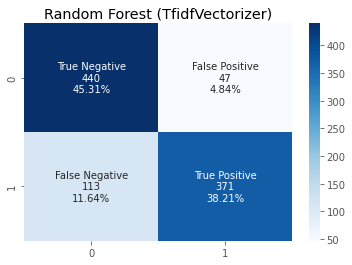

In [33]:
confusion_matrix_plot(y_test, rt_y_pred, 'Random Forest (TfidfVectorizer)')

### ROC Curve and AUC

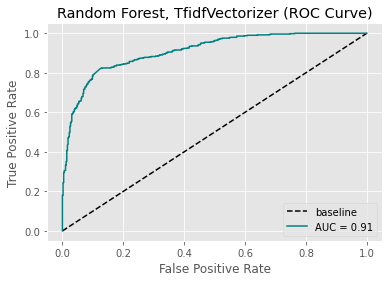

In [34]:
plot_roc_auc(rt_y_pred_prob, rt_auc, 'Random Forest', 'TfidfVectorizer')

### Misclassified Observations

In [35]:
display_misclassification(rt_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,tell damage way close thing,surfing,scubadiving
2,joe rogan experience 1749 shane dorian,surfing,scubadiving
3,place north shore hi everyone new hop see knew good place north shore massachusetts place gloucester rockport area t...,scubadiving,surfing
4,tray gopro 4 know good tray room 2 mountable light buy sweden,scubadiving,surfing
...,...,...,...
155,tank rack hi rack fit pickup truck bed hold tank saw one youtube vid find internet start think might custom fabricat...,scubadiving,surfing
156,please help x200b one ocean worker enthusiast help answer question fashion master degree project work get informatio...,scubadiving,surfing
157,affordable spot work remotely,surfing,scubadiving
158,thought waxjobs,surfing,scubadiving


---

# KNN Model - CountVectorizer

In [36]:
# Set up pipeline
knn_cvec_pipe = Pipeline([('cvec', CountVectorizer()), 
                         ('knn', KNeighborsClassifier())])

# Hyperparameters tuning
knn_cvec_params = {'cvec__ngram_range' : [(1, 1), (1, 2)],
                   'cvec__max_features' : [6500, 7000, 7500],
                   'cvec__ngram_range': [(1,1), (1,2)],
                   'knn__p': [1, 2],
                   'knn__weights' : ['uniform', 'distance'],
                   'knn__metric': ['minkowski', 'euclidean'],
                   'knn__n_neighbors': np.arange(1, 7, 2)}

# GridSearchCV
knn_cvec_gs = GridSearchCV(knn_cvec_pipe, 
                          param_grid = knn_cvec_params, 
                          cv = 5,
                          verbose = 1,
                          n_jobs = -1) 

start_time = time.time()

# Fit model
knn_cvec_gs.fit(X_train, y_train)

# Show metrics and best parameters
print(knn_cvec_gs.best_params_)
kc_y_pred, kc_y_pred_prob, kc_accuracy, kc_sensitivity, kc_specificity, kc_precision, kc_f1score, kc_auc = class_metrics(
    knn_cvec_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'cvec__max_features': 7000, 'cvec__ngram_range': (1, 1), 'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
Accuracy: 0.7
Sensitivity: 0.55
Specificity: 0.85
Precision: 0.78
F1: 0.65
AUC: 0.77
Elapsed time: 14.17 seconds


#### Hyperparameters setting example 1:
knn_cvec_params = {'cvec__ngram_range' : [(1, 1), (1, 2)],
                   'cvec__max_features' : [5000, 6000, 7000],
                   'cvec__ngram_range': [(1,1), (1,2)],
                   'knn__p': [1, 2],
                   'knn__weights' : ['uniform', 'distance'],
                   'knn__metric': ['minkowski', 'euclidean'],
                   'knn__n_neighbors': np.arange(5, 10, 1)}
                  
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

{'cvec__max_features': 7000, 'cvec__ngram_range': (1, 1), 'knn__metric': 'minkowski', 'knn__n_neighbors': 6, 'knn__p': 2, 'knn__weights': 'distance'}

Accuracy: 0.7
Sensitivity: 0.53
Specificity: 0.87
Precision: 0.8
F1: 0.64
AUC: 0.79

Elapsed time: 26.8 seconds

#### Hyperparameters setting example 2:
knn_cvec_params = {'cvec__ngram_range' : [(1, 1), (1, 2)],
                   'cvec__max_features' : [6000, 6500, 7000],
                   'cvec__ngram_range': [(1,1), (1,2)],
                   'knn__p': [1, 2],
                   'knn__weights' : ['uniform', 'distance'],
                   'knn__metric': ['minkowski', 'euclidean'],
                   'knn__n_neighbors': np.arange(1, 10, 2)}

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

{'cvec__max_features': 7000, 'cvec__ngram_range': (1, 1), 'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}

Accuracy: 0.71
Sensitivity: 0.59
Specificity: 0.82
Precision: 0.77
F1: 0.67
AUC: 0.78

Elapsed time: 22.31 seconds


### Confusion Matrix

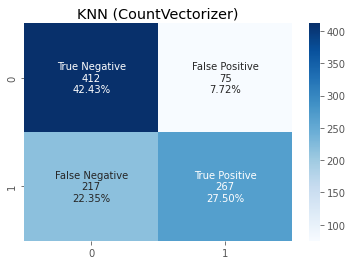

In [37]:
confusion_matrix_plot(y_test, kc_y_pred, 'KNN (CountVectorizer)')

### ROC Curve and AUC

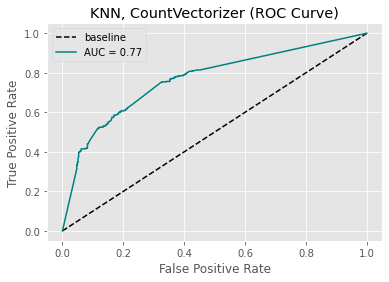

In [38]:
plot_roc_auc(kc_y_pred_prob, kc_auc, 'KNN', 'CountVectorizer')

### Misclassified Observations

In [39]:
display_misclassification(kc_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,tell damage way close thing,surfing,scubadiving
2,oceanography book recommendation happy new year lad new leaf learn want get well understand ocean storm already extr...,surfing,scubadiving
3,first template ive make first go hand shape,surfing,scubadiving
4,maybe research implication well,scubadiving,surfing
...,...,...,...
287,myrtle beach early may hi go myrtle beach early may newbie wonder water cold shark heard sharkage myrtle beach wonde...,scubadiving,surfing
288,harmful flip go upside play around safety stop new find strong answer confident understand science apology stupid qu...,scubadiving,surfing
289,code edit work could lovely person send code active thank,scubadiving,surfing
290,purpose ive always passionate ocean since meeting half developed love ocean recently start together brings smile fac...,scubadiving,surfing


---

# KNN Model - TfidfVectorizer

In [40]:
# Set up pipeline
knn_tfidf_pipe = Pipeline([('tfidf',TfidfVectorizer()),
                          ('knn', KNeighborsClassifier())])

# Hyperparameters tuning
knn_tfidf_params = {'tfidf__max_features': [6500, 7000, 7500],
                    'tfidf__ngram_range': [(1,1), (1,2)],
                    'knn__p': [1, 2],
                    'knn__weights' : ['uniform', 'distance'],
                    'knn__metric': ['minkowski', 'euclidean'],
                    'knn__n_neighbors': np.arange(7, 14, 2)}

# GridSearchCV
knn_tfidf_gs = GridSearchCV(knn_tfidf_pipe, 
                          param_grid = knn_tfidf_params, 
                          cv = 5,
                          verbose = 1,
                          n_jobs = 7) 

start_time = time.time()

# Fit model
knn_tfidf_gs.fit(X_train, y_train)

# Show metrics and best parameters
print(knn_tfidf_gs.best_params_)
kt_y_pred, kt_y_pred_prob, kt_accuracy, kt_sensitivity, kt_specificity, kt_precision, kt_f1score, kt_auc = class_metrics(
    knn_tfidf_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'knn__metric': 'minkowski', 'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.82
Sensitivity: 0.73
Specificity: 0.92
Precision: 0.9
F1: 0.81
AUC: 0.91
Elapsed time: 26.12 seconds


#### Hyperparameters setting example 1:
knn_tfidf_params = {'tfidf__max_features': [5000, 5500, 6500],
                    'tfidf__ngram_range': [(1,1), (1,2)],
                    'knn__p': [1, 2],
                    'knn__weights' : ['uniform', 'distance'],
                    'knn__metric': ['minkowski', 'euclidean'],
                    'knn__n_neighbors': np.arange(5, 10, 2)}

Fitting 5 folds for each of 144 candidates, totalling 720 fits

{'knn__metric': 'minkowski', 'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'distance', 'tfidf__max_features': 6500, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.54
Sensitivity: 0.08
Specificity: 1.0
Precision: 1.0
F1: 0.16
AUC: 0.86

Elapsed time: 19.68 seconds

#### Hyperparameters setting example 2:
knn_tfidf_params = {'tfidf__max_features': [6000, 6500, 7000],
                    'tfidf__ngram_range': [(1,1), (1,2)],
                    'knn__p': [1, 2],
                    'knn__weights' : ['uniform', 'distance'],
                    'knn__metric': ['minkowski', 'euclidean'],
                    'knn__n_neighbors': np.arange(5, 10, 2)}
                    
Fitting 5 folds for each of 144 candidates, totalling 720 fits

{'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance', 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}

Accuracy: 0.75
Sensitivity: 0.55
Specificity: 0.94
Precision: 0.91
F1: 0.69
AUC: 0.88

Elapsed time: 18.26 seconds             

#### Note: 
'tfidf__min_df' and 'tfidf__max_df' were removed as they did not make any difference to the model scores. 
It is noted that we should use a odd number for n_neighbors as a problem might arise where an observation could encounter a scenario whereby half the neighbors belong to binary class 1, and the other half belong to binary class 0.


### Confusion Matrix

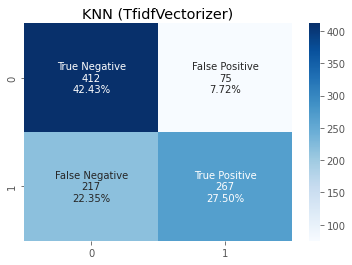

In [41]:
confusion_matrix_plot(y_test, kc_y_pred, 'KNN (TfidfVectorizer)')

### ROC Curve and AUC

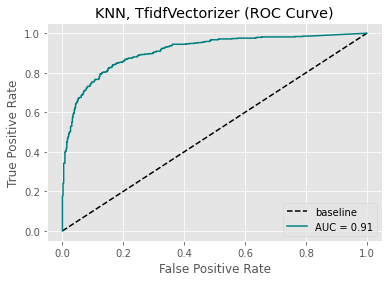

In [42]:
plot_roc_auc(kt_y_pred_prob, kt_auc, 'KNN', 'TfidfVectorizer')

### Misclassified Observations

In [43]:
display_misclassification(kt_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,tell damage way close thing,surfing,scubadiving
2,padi open water costa rica,scubadiving,surfing
3,joe rogan experience 1749 shane dorian,surfing,scubadiving
4,combat v recreational google found get license include rebreather take day 2 3 however u army combat course 8 week 5...,scubadiving,surfing
...,...,...,...
165,affordable spot work remotely,surfing,scubadiving
166,myrtle beach early may hi go myrtle beach early may newbie wonder water cold shark heard sharkage myrtle beach wonde...,scubadiving,surfing
167,harmful flip go upside play around safety stop new find strong answer confident understand science apology stupid qu...,scubadiving,surfing
168,code edit work could lovely person send code active thank,scubadiving,surfing


---

# Model Evaluation

| Models                   | Vectorizer      |   Accuracy |   F1-Score |   AUC Score |
|:-------------------------|:----------------|-----------:|-----------:|------------:|
| Logistic Regression      | CountVectorizer |       0.85 |       0.84 |        0.93 |
| Logistic Regression      | TfidfVectorizer |       0.87 |       0.86 |        0.94 |
| Random Forest Classifier | CountVectorizer |       0.8  |       0.81 |        0.89 |
| Random Forest Classifier | TfidfVectorizer |       0.84 |       0.82 |        0.91 |
| KNeighbors Classifier    | CountVectorizer |       0.7  |       0.65 |        0.77 |
| KNeighbors Classifier    | TfidfVectorizer |       0.82 |       0.81 |        0.91 |

Refering to the score table above, the model built using the Logistic Regression algorithm and Tfid Vectorizer is the best performing model, since it has the highest accuracy score of 0.87 and AUC score at 0.94. This indicates that the model has a decently good ability to distinguish between whether an observation is from r/scubadiving or r/surfing, and in general, can classify the observations to the right category 87% of the time.

Meantime, KNeighbors Classifier performed the worst. In general, the KNN algorithm does not seem to perform well compared to the other algorithms for balanced data binary classification problems, which is the exact problem we are dealing with in this project. Problem arises when there is an even (>1) number of, say n nearest neighbors and half of n neighbors belong to label 0 and the other half belong to label 1. Then, (n+1)th nearest neighbors have to be found (according to the algorithm) and if the same case arises again, (n+2)th nearest neighbors are found and so on. If this case continues to arise, and in this case, with our balanced data between scubadiving and surfing, at a particular instant, there will be no more samples remaining in the data set and at each nth nearest neighbors consideration, same number of instances of the both the labels are found. Hence, no decision can be taken about the prediction of a test sample, even though after reaching the maximum value of k as per the data set.
[(source)](https://towardsdatascience.com/algorithmic-incompleteness-of-k-nearest-neighbour-in-binary-classification-8149bfb97c6c)

We can also see that models built using Tfidf Vectorizer perform better than those using Count Vectorizer. This is understable as count vectorizer gives more importance to the words which occurs more frequently but tfidf vectorizer works in such a way that it will give importance to both sets of words which occur more and less in the dataset.



# Conclusion
In order for the water sporting goods company to be able to offer highly personalized product recommendations to forum users, a predictor model that is able to distinguish between the two water sports categories is essential. Hence, we will select the best model based on the highest AUC score, which is the Logistic Regression algorithm and Tfid Vectorizer model, since this score is a measure of a model's separability between two different categories. The higher the AUC score of a model, the better its perfomance in distinguishing different categories. Meanwhile, it is also important to note that this model not only performs better than the rest in terms of its AUC score, but it also has the highest accuracy score.

We will cover the model with more details below with:
1. Confusion Matrix to show a summary of the number / percentage of observation that were rightly / wrongly predicted.
2. ROC Curve of the model to show the trade-off between sensitivity (or TPR) and specificity (1 – FPR). 
3. Observations that were misclassified 
4. Word Coefficiencies


## Final Model: Logistic Regression (Count Vectorizer)

In [44]:
# Set up pipleline
lr_tfidf_pipe = Pipeline([('tfidf',TfidfVectorizer()),
                          ('lr',LogisticRegression(random_state= 42))])

# Pipe parameters
lr_tfidf_params = {'tfidf__max_features': [6500, 6800, 7000],
                   'tfidf__ngram_range': [(1,1), (1,2)],
                   'lr__penalty': ['l1', 'l2'],
                   'lr__solver':['liblinear'], 
                   'lr__C': np.linspace(1, 4, 20)}

start_time = time.time()

# tfidf grid search
# Instantiate GridSearchCV.
lr_tfidf_gs = GridSearchCV(lr_tfidf_pipe, 
                           lr_tfidf_params, 
                           cv = 5,
                           verbose = 1,
                           n_jobs = 7) 

# Fit grid search
lr_tfidf_gs.fit(X_train, y_train)

# Show best params, metrics and unpack function return values into variables
print(lr_tfidf_gs.best_params_)
lt_y_pred, lt_y_pred_prob, lt_accuracy, lt_sensitivity, lt_specificity, lt_precision, lt_f1score, lt_auc = class_metrics(
    lr_tfidf_gs, X_test, y_test)

end_time = time.time()
print(f'Elapsed time: {round((end_time - start_time), 2)} seconds')


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'lr__C': 1.9473684210526314, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_features': 6800, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.87
Sensitivity: 0.83
Specificity: 0.9
Precision: 0.9
F1: 0.86
AUC: 0.94
Elapsed time: 26.58 seconds


## Confusion Matrix

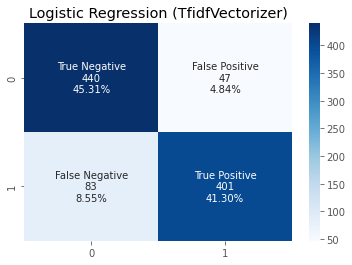

In [45]:
confusion_matrix_plot(y_test, lt_y_pred, 'Logistic Regression (TfidfVectorizer)')

### ROC Curve and AUC

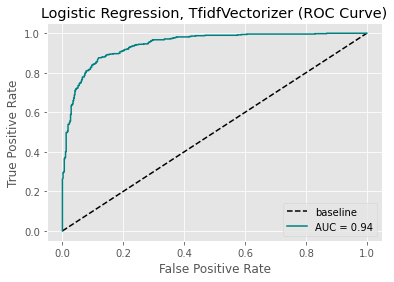

In [46]:
plot_roc_auc(lt_y_pred_prob, lt_auc, 'Logistic Regression', 'TfidfVectorizer')

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the 'signal' from the 'noise'. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. Classifiers that give curves closer to the top-left corner indicate a better performance. The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. [(source)](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/)

As mentioned during model evaluation, 0.94 is a good AUC score, and hence would be useful in helping the water sporting goods company to identify forum users' preference in water sports.

### Misclassified Observations

In [47]:
display_misclassification(lt_y_pred)

,text,actual,predicted
0,day corona,scubadiving,surfing
1,maybe research implication well,scubadiving,surfing
2,joe rogan experience 1749 shane dorian,surfing,scubadiving
3,place north shore hi everyone new hop see knew good place north shore massachusetts place gloucester rockport area t...,scubadiving,surfing
4,also hate fish bite,scubadiving,surfing
5,albino cowry small large,scubadiving,surfing
6,mentawaii island 2019 5 u perfect poo stance love go back someday,surfing,scubadiving
7,hand point unadorned left ring finger pause moment think problem,scubadiving,surfing
8,pretty fishies short compilation,scubadiving,surfing
9,shark kill dolphin brings shore,surfing,scubadiving


Most of the text observations that have been 'misclassfied' actually contain texts that are quite random. Also, many of these observations have very few word tokens, eg. less than 5. Hence it would be difficult to classify them correctly as there is a lack to the lack of word tokens for the model to do its prediction.


### Word Coefficients

In [48]:
coef_names = lr_tfidf_gs.best_estimator_.named_steps['tfidf'].get_feature_names()
coef_vals = lr_tfidf_gs.best_estimator_.named_steps['lr'].coef_[0]

coef_df = pd.DataFrame ({
    'word' : coef_names,
    'coef' : coef_vals}).set_index('word')

coef_df.reindex(coef_df['coef'].sort_values(ascending = False).index)[:20]

,coef
word,
underwater,5.389985
bali,3.697885
certify,3.484016
sea,3.435655
gear,3.107958
open,2.912474
reef,2.888953
padi,2.836446
computer,2.748913


In [49]:
coef_df.reindex(coef_df['coef'].sort_values(ascending = True).index)[:20]

,coef
word,
kook,-2.794064
paddle,-2.710103
repair,-2.705063
winter,-2.442005
shape,-2.432595
break,-2.298682
ride,-2.242291
session,-2.237703
swell,-2.146998


Above shows the top 20 words with the highest coefficient with category 1, scubadiving. This means that the higher the coefficient of a word, the higher the chance the observation that contains the word, will be placed in category 1. Meantime, the lower the coefficient of a word, the chance of the observation that contain the word will be classified as cateogry 0 will be higher. In this case, observations containing words with higher coefficients will most likely be classified as category 1, which is scubadiving, while observations containing words with low coefficients (in this case, negative coefficients) will most likely be classified as category 0, which is surfing.

---

# Appendix

### Score Table

In [50]:
data = {'Models': ['Logistic Regression', 'Logistic Regression', 'Random Forest Classifier', 'Random Forest Classifier', 
                   'KNeighbors Classifier', 'KNeighbors Classifier'], 
        'Vectorizer': ['CountVectorizer', 'TfidfVectorizer', 'CountVectorizer', 'TfidfVectorizer', 
                           'CountVectorizer', 'TfidfVectorizer'], 
        'Accuracy': [lc_accuracy, lt_accuracy, rc_accuracy, rt_accuracy, kc_accuracy, kt_accuracy],
        'F1-Score': [lc_f1score, lt_f1score, rc_f1score, rt_f1score, kc_f1score, kt_f1score],
        'AUC Score': [lc_auc, lt_auc, rc_auc, rt_auc, kc_auc, kt_auc]}  

In [51]:
# Create DataFrame  
df = pd.DataFrame(data)  

In [52]:
score_table = df.to_markdown(index=False) 

In [53]:
print(score_table)

| Models                   | Vectorizer      |   Accuracy |   F1-Score |   AUC Score |
|:-------------------------|:----------------|-----------:|-----------:|------------:|
| Logistic Regression      | CountVectorizer |       0.85 |       0.84 |        0.93 |
| Logistic Regression      | TfidfVectorizer |       0.87 |       0.86 |        0.94 |
| Random Forest Classifier | CountVectorizer |       0.8  |       0.81 |        0.89 |
| Random Forest Classifier | TfidfVectorizer |       0.84 |       0.82 |        0.91 |
| KNeighbors Classifier    | CountVectorizer |       0.7  |       0.65 |        0.77 |
| KNeighbors Classifier    | TfidfVectorizer |       0.82 |       0.81 |        0.91 |
